In [11]:
# import relevant libraries
import numpy as np
import cvxpy as cvx 
from sklearn.linear_model import LinearRegression
import time
import pandas as pd
import matplotlib.pyplot as plt


In [8]:
# import data
ob_df = pd.read_csv('ob_df.csv')
ob_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
ob_df.head()

,ms
0,10673.75
1,10673.75
2,10675.80
3,10674.05
4,10674.70


Text(0, 0.5, 'price ($)')

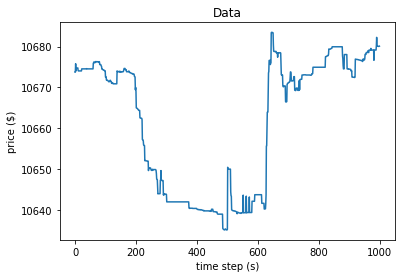

In [15]:
# plot data
plt.plot(ob_df[:1000])
plt.title('Data')
plt.xlabel('time step (s)')
plt.ylabel('price ($)')

## Toy MO

Text(0, 0.5, 'price ($)')

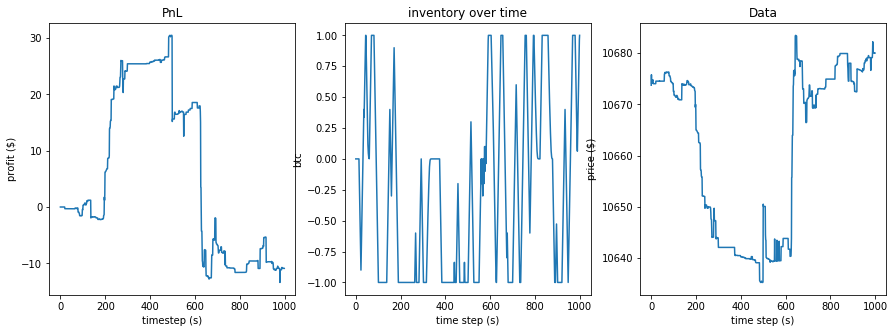

In [16]:
s = ob_df.ms.tolist()[:1000]# load data into list

# fit trend line on moving window
w = 15 # parameter for calibrating period. I.e., the bot look into the data 15 data points before the current point to project market moving in the next window.
ord_list = [0] #start with 0 orders.
# start moving window
for i in range(w, len(s)):
    start = time.time()
    x = np.array(list(range(w))).reshape((-1, 1))
    y = np.array(s[i-w:i])
    model = LinearRegression() # the bot use the data 15 seconds before the current time and fit a linear regression to project price movement in the next window
    model.fit(x, y)
    #print (model.coef_, model.intercept_)

    # create a set of projected data
    proj_s = np.array([model.coef_*i + model.intercept_ for i in range(15, 31)])
    proj_s = proj_s[1:] - proj_s[:-1]
    proj_s = proj_s.T

    # solve optimization problem on a window of time T=15
    #print (sum(ord_list))
    """
    The code block below makes use of CVXPy to solve an optimization.
    """
    # inputs:
    N = 15 # size of moving window
    max_pos = 0.1 # max position size

    # matrices A and B as shown in MPC model formulation
    A = np.matrix('1,1;0,0') 
    B = np.matrix('0;1')

    X = cvx.Variable((2,N+1)) # combination state vectors by time steps
    U = cvx.Variable((1,N)) # combination of actions vectors by time steps

    con = [X[:,0] == np.array([sum(ord_list),0])] # constraint 1: starting condition, specified to be changed based on the current inventory of the bot itself
    con.extend([X[:,1:16] == A*X[:,0:15] + B*U]) # constraint 2: update condition
    con.extend([cvx.norm(U[0,j],'inf')<=max_pos for j in range(0,N)]) # constraint 3: maximum trading position
    con.extend([cvx.norm(X[0,:],'inf')<=1]) # constraint 4: maximum inventory size

    con.extend([X[0, -1] == 0]) #neutral exposure
    obj = cvx.Maximize(sum(proj_s*X[0,1:16])) # objective function

    prob = cvx.Problem(obj, con) # insert objective function and constraints into cvxpy

    #output
    prob.solve() # solve using cvxpy magic
    ord_list.append(U.value[0][0]) # the bot executes only the first action, the window moves the process repeats
    
ord_list = ord_list[1:] # discard the first (zero place-holder) action

# # plot result (inventory over time)
# plt.plot(list(range(14, 30)), X.value[0])

# plot the pnl of the bot
act_s = ob_df.ms.tolist()[1:1001] # data moves up 1 step to account for latency.
ord_list = [0]*15 + ord_list
ds = np.array(act_s[1:]) - np.array(act_s[:-1])
pnl = np.cumsum(np.cumsum(np.array(ord_list[:-1]))*ds)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(pnl)
plt.title('PnL')
plt.xlabel('timestep (s)')
plt.ylabel('profit ($)')

# plot inventory over time
plt.subplot(1,3,2)
plt.plot(np.cumsum(ord_list))
plt.title('inventory over time')
plt.ylabel('btc')
plt.xlabel('time step (s)')

# plot price time series
plt.subplot(1,3,3)
plt.plot(act_s)
plt.title('Data')
plt.xlabel('time step (s)')
plt.ylabel('price ($)')

0.021428571428519456 0.7591618229792702
-0.125 0.5108642537057348
0.0 0.24053541467800013
-0.04642857142867537 0.1597595131461764
-0.04642857142867537 0.1597595131461764
-0.04642857142867537 0.1597595131461764
-0.04642857142867537 0.1597595131461764
-0.014285714285766258 0.21249283301215832
-0.017857142857142856 0.21180140871722478
0.024999999999896057 0.13725679790620768
0.03571428571428571 0.1287702431084319
0.03564285714271266 0.1287897551066029
0.03571428571428571 0.12876968840942818
0.03571428571428571 0.12876968840942818
0.03571428571428571 0.12876968840942818
0.03571428571428571 0.12876968840942818
0.03571428571428571 0.12876968840942818
0.03571428571428571 0.12876968840942818
0.03571428571428571 0.12876968840942818
0.03571428571428571 0.12876968840942818
0.03571428571428571 0.12876968840942818
0.0 0.0
0.003571428571506528 0.012876968841223895
0.0 0.018898223650873867
0.003571428571506528 0.022868300848473626
0.0 0.026726124191825813
0.0 0.026726124191825813
0.0 0.02672612419182

-0.3678571428572468 0.9593613096479225
-0.3678571428572468 0.9593613096479225
-0.35357142857148055 0.9624939119873314
-0.2821428571429091 0.9488804574072645
-0.2785714285714026 0.9498410930473014
-0.4357857142857548 1.0802999701520009
-0.3929285714287159 1.1082773289006274
-0.125 0.6235697921756007
-0.1285714285713766 0.6226998490769619
-0.1285714285713766 0.6226998490769619
-0.125 0.623283356794315
-0.125 0.623283356794315
-0.125 0.623283356794315
-0.14642857142851945 0.6237743083477649
-0.16071428571428573 0.622546203514117
-0.16428571428566233 0.6217568919221639
-0.16071428571428573 0.622546203514117
-0.16071428571428573 0.622546203514117
-0.14285714285714285 0.6304355475316038
0.0035714285713766003 0.21083531633035424
-0.024999999999896057 0.14485214136204147
-0.028571428571402584 0.14356965173034886
-0.028571428571402584 0.14356965173034886
-0.028571428571402584 0.14356965173034886
-0.028571428571402584 0.14356965173034886
-0.028571428571402584 0.14356965173034886
-0.0249999999998

-0.26785714285714285 0.8977447025855394
-0.25721428571432625 0.9017314439115078
-0.26428571428563635 0.90007328499814
-0.26428571428563635 0.90007328499814
-0.27142857142851945 0.8983427371940936
-0.2750714285714691 0.8973375272187434
-0.2750714285714691 0.8973375272187434
-0.025071428571469108 0.0724593130024269
-0.007142857142883129 0.08211129828560762
1.082142857142831 3.902500496149651
1.0535714285714286 3.912137043215285
1.0571428571428052 3.911150650149218
1.0607142857141818 3.9101607462128705
1.0607857142857549 3.9101413598591073
1.0535714285714286 3.911998260193169
1.042928571428612 3.9146465168696927
1.049999999999922 3.9126662630121887
1.049999999999922 3.9126662630121882
1.0571428571428052 3.910651094075161
0.6643571428572353 4.262553855665353
0.5965000000000406 4.280115398143763
0.5892857142857143 4.281199722183411
0.3392857142857143 4.400035672396912
-0.7464285714286234 1.5887061993187461
-0.7178571428570909 1.5973535639181697
-0.7215000000000406 1.5957696642771666
-0.7215

0.03571428571428571 0.6498761891506226
0.03571428571428571 0.6498761891506226
0.03571428571428571 0.6498761891506226
0.025000000000025984 0.649139760430588
0.03571428571428571 0.6498761891506226
0.09285714285709089 0.68294999368771
0.08578571428578081 0.6833621899502165
0.017857142857142856 0.6398625809104318
-0.31792857142863795 0.9727905709337552
-0.31792857142863795 0.9727905709337551
-0.2857142857142857 0.9720061308278639
-0.16785714285716885 0.8965423945948161
-0.1642142857142192 0.8973203105890576
-0.125 0.9154527373301933
-0.125 0.9154527373301933
-0.125 0.9154527373301933
-0.1285714285713766 0.9148603885904633
-0.1285714285713766 0.9148603885904633
-0.17849999999985552 0.917365463082606
-0.23921428571416722 0.8744089578165277
-0.23921428571416722 0.8744089578165276
-0.23921428571416722 0.8744089578165276
-0.003499999999933477 0.20963088308435412
0.16785714285716885 0.6533506887182755
0.014285714285766258 0.9031787853836106
0.1892857142856883 1.0994802946695514
0.189214285714245

0.13221428571432625 0.32410055286475903
0.12864285714294965 0.3252602490187271
0.12864285714294965 0.3252602490187271
0.14992857142845292 0.344995334188731
0.07499999999994802 0.23932255579896114
0.07499999999994802 0.23932255579896114
0.07499999999994802 0.23932255579896114
0.07499999999994802 0.23932255579896114
0.04278571428559579 0.21573369117967547
0.07135714285699837 0.233898209588643
0.04278571428559579 0.2634353210317646
0.04278571428559579 0.2634353210317646
0.04278571428559579 0.2634353210317646
0.014285714285636329 0.24424005421187372
0.04278571428559579 0.21599807491543427
0.04278571428559579 0.21599807491543432
0.04278571428559579 0.21599807491543432
0.0 0.15118578920355338
0.0 0.15118578920355338
-0.17857142857142858 0.6613606876611521
0.0 0.9569296137722169
0.0 0.9569296137722169
0.0 0.9569296137722169
-0.028571428571402584 0.9505100671508339
0.0 0.944911182523068
0.0 0.944911182523068
0.0 0.944911182523068
0.07500000000007796 0.9828439056418341
0.22142857142859743 1.105

Text(0, 0.5, 'price ($)')

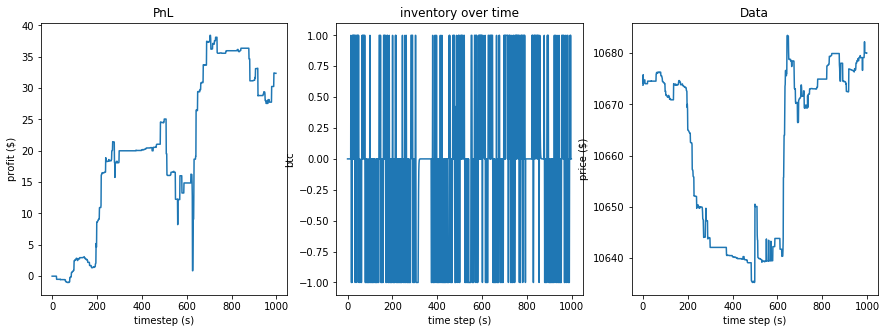

In [18]:
w = 15 # parameter for calibrating period. I.e., the bot look into the data 15 data points before the current point to project market moving in the next window.

s = ob_df.ms.tolist()[:1000]# load data into list
act_s = ob_df.ms.tolist()[1:1001] # data moves up 1 step to account for latency.
ds = np.array(act_s[1:]) - np.array(act_s[:-1])

# fit trend line on moving window
ord_list = [0] #start with 0 orders.
# start moving window
for i in range(w, len(s)):
    start = time.time()
    x = np.array(list(range(w))).reshape((-1, 1))
    y = np.array(s[i-w:i])
    model = LinearRegression() # the bot use the data 15 seconds before the current time and fit a linear regression to project price movement in the next window
    model.fit(x, y)
    ds_t = ds[i-w:i-1]
    #print (model.coef_, model.intercept_)
    tmp_ord_list = []
    print (np.mean(ds_t), np.std(ds_t))

  # create a set of projected data
    projs = []
    for _ in range(50):
        nxt_inc = np.random.normal(loc=np.mean(ds_t), scale=np.std(ds_t), size=w+1)
        proj_s = nxt_inc + np.array([model.coef_[0]*i + model.intercept_ for i in range(w, 2*w+1)])
        proj_s_org = proj_s
        proj_s_org = proj_s_org.T
        proj_s = proj_s[1:] - proj_s[:-1]
        proj_s = proj_s.T

        # solve optimization problem on a window of time T=15
        #print (sum(ord_list))
        """
        The code block below makes use of CVXPy to solve an optimization.
        """
        # inputs:
        N = 15 # size of moving window
        max_pos = 1 # max position size

        # matrices A and B as shown in MPC model formulation
        A = np.matrix('1,1;0,0') 
        B = np.matrix('0;1')

        X = cvx.Variable((2,N+1)) # combination state vectors by time steps
        U = cvx.Variable((1,N)) # combination of actions vectors by time steps

        con = [X[:,0] == np.array([sum(ord_list),0])] # constraint 1: starting condition, specified to be changed based on the current inventory of the bot itself
        con.extend([X[:,1:w+1] == A*X[:,0:w] + B*U]) # constraint 2: update condition
        con.extend([cvx.norm(U[0,j],'inf')<=max_pos for j in range(0,N)]) # constraint 3: maximum trading position
        con.extend([cvx.norm(X[0,:],'inf')<=1]) # constraint 4: maximum inventory size

        con.extend([X[0, -1] == 0]) #neutral exposure
        
        
        #con.extend([np.std(proj_s*X[0,1:16]) < 0.5])
        #con.extend([cvx.min(cvx.multiply(proj_s, X[0,1:w+1])) >= -0.5])
        obj = cvx.Maximize(X[0,1:w+1]@proj_s-cvx.tv(cvx.diag(proj_s_org[1:]*X[0,1:w+1])))
        #obj = cvx.Maximize(sum(proj_s*X[0,1:16])-np.std(np.cumsum(proj_s*X[0,1:16]))) # objective function

        prob = cvx.Problem(obj, con) # insert objective function and constraints into cvxpy

        #output
        prob.solve() # solve using cvxpy magic
        tmp_ord_list.append(U.value[0][0])
    v = np.mean(tmp_ord_list)
    #print (v)
    if abs(v) <= 0.0:
        v = 0
    ord_list.append(v) # the bot executes only the first action, the window moves the process repeats
    
ord_list = ord_list[1:] # discard the first (zero place-holder) action


# plot the pnl of the bot
ord_list = [0]*w + ord_list
pnl = np.cumsum(np.cumsum(np.array(ord_list[:-1]))*ds)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(pnl)
plt.title('PnL')
plt.xlabel('timestep (s)')
plt.ylabel('profit ($)')

# plot inventory over time
plt.subplot(1,3,2)
plt.plot(np.cumsum(ord_list))
plt.title('inventory over time')
plt.ylabel('btc')
plt.xlabel('time step (s)')

# plot price time series
plt.subplot(1,3,3)
plt.plot(act_s)
plt.title('Data')
plt.xlabel('time step (s)')
plt.ylabel('price ($)')

Text(0, 0.5, 'profit ($)')

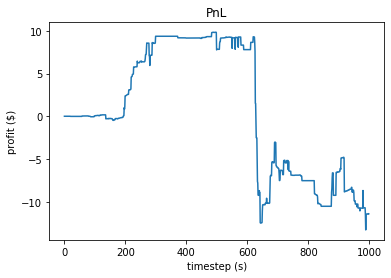

In [19]:
## fixed size performance -- this is effectively the position sizing layer mentioned in the paper
## only position size is scaled by sign - the position size changes are not recorded by the bot and hence not be reflected in the starting position X0 at each iteration.
ord_list_1 = [0.015*np.sign(item) for item in ord_list]
pnl = np.cumsum(np.cumsum(np.array(ord_list_1[:-1]))*ds)
plt.plot(pnl)
plt.title('PnL')
plt.xlabel('timestep (s)')
plt.ylabel('profit ($)')

0.021428571428519456 0.7591618229792702
8.106942267846398e-12
-0.125 0.5108642537057348
8.101521505647606e-12
0.0 0.24053541467800013
8.084405204231091e-12
-0.04642857142867537 0.1597595131461764
8.098666977257113e-12
-0.04642857142867537 0.1597595131461764
8.091630934250765e-12
-0.04642857142867537 0.1597595131461764
8.093134370151596e-12
-0.04642857142867537 0.1597595131461764
8.094548345296997e-12
-0.014285714285766258 0.21249283301215832
8.098081131132671e-12
-0.017857142857142856 0.21180140871722478
8.111475740571405e-12
0.024999999999896057 0.13725679790620768
8.119948337608065e-12
0.03571428571428571 0.1287702431084319
8.107430639418432e-12
0.03564285714271266 0.1287897551066029
8.103881120444844e-12
0.03571428571428571 0.12876968840942818
8.101092737033681e-12
0.03571428571428571 0.12876968840942818
8.099421727615252e-12
0.03571428571428571 0.12876968840942818
8.097876688875051e-12
0.03571428571428571 0.12876968840942818
8.09853532208921e-12
0.03571428571428571 0.12876968840942

8.11667446372847e-12
-0.0035714285713766003 0.08294810278160344
8.117897830966921e-12
0.0 0.08194248854252391
8.118035301000233e-12
0.0 0.08194248854252391
8.119203811385182e-12
-0.0035714285713766003 0.08076660756732937
8.119353973530867e-12
0.0036428571429496515 0.08920971050817883
8.119285561008998e-12
0.03928571428579224 0.11658683371597613
8.118866084302354e-12
0.0607142857143117 0.1337094016200908
8.112468347924187e-12
0.050071428571495095 0.13217978248558984
8.105758612602335e-12
0.0607142857143117 0.12127090604533089
8.099553436994508e-12
0.0607142857143117 0.12127090604533088
8.092636114820307e-12
0.03571428571428571 0.152863818278669
8.088727356634698e-12
0.03571428571428571 0.152863818278669
8.090141737660855e-12
0.042857142857168844 0.14863322890472666
8.091343087214382e-12
0.03571428571428571 0.1481174382378797
8.092698517724125e-12
0.0 0.20266087084431617
8.098266957346063e-12
0.0 0.20266087084431614
8.108423356204253e-12
0.0 0.20266087084431617
8.115822134282855e-12
0.0 

8.032701613695305e-12
-0.021500000000092508 1.5685305111107437
8.089070971083947e-12
-0.007214285714326252 1.569571696745367
8.052818544875557e-12
-0.2393571428571834 1.2852436460031456
7.982600521064558e-12
-0.2393571428571834 1.2852436460031456
7.942166226114729e-12
-0.4107142857142857 1.0627187121832031
7.918488461258124e-12
-0.2393571428571834 0.910867530524212
7.914113000240483e-12
-0.2393571428571834 0.910867530524212
7.942814028596583e-12
-0.2393571428571834 0.910867530524212
7.952432329248335e-12
-0.24650000000006653 0.9093533613036732
7.956925468232944e-12
-0.37507142857157305 0.9891591280539511
7.986962708616203e-12
-0.3714285714286234 0.9904389873966848
7.974846195185869e-12
-0.3714285714286234 0.9904389873966848
7.985710539111027e-12
-0.1214285714286234 0.478731316575051
8.006307869411069e-12
-0.13928571428576625 0.4691095559786607
8.033222476416093e-12
-0.1214285714286234 0.469313436885319
8.016741146736917e-12
-0.13571428571438965 0.4623034607226903
8.017923529355845e-12


8.084422562010105e-12
-0.014285714285766258 0.2003822877013937
8.08977341657912e-12
-0.014285714285766258 0.2003822877013937
8.092503354031255e-12
-0.007142857142883129 0.19897697538821954
8.090307156002752e-12
-0.007142857142883129 0.19897697538821954
8.08729934655683e-12
-0.007142857142883129 0.19897697538821954
8.082609119848832e-12
-0.010714285714259728 0.19926523192219767
8.07709498150988e-12
-0.046428571428545444 0.1407432892515149
8.07333501329682e-12
-0.05000000000005197 0.14015297764516166
8.069224830736587e-12
-0.05000000000005197 0.14015297764516166
8.070726469887529e-12
-0.046428571428545444 0.1420063953718073
8.073364196781538e-12
-0.05000000000005197 0.1414213562371809
8.07898654756072e-12
-0.03928571428579224 0.10381744181248576
8.083533912560459e-12
-0.042857142857168844 0.10326308781999607
8.085072881679472e-12
-0.042857142857168844 0.10326308781999607
8.079728325114106e-12
-0.042857142857168844 0.10326308781999606
8.07686314302392e-12
-0.042857142857168844 0.103263087

7.965539420604788e-12
0.3107857142857548 0.7916290778760469
7.974985625242255e-12
0.3107857142857548 0.7916290778760469
7.989326117696936e-12
0.11435714285718339 0.41232054228713527
8.002591412662432e-12
0.11435714285718339 0.41232054228713527
8.03197550548621e-12
0.11435714285718339 0.41232054228713527
8.025732099832613e-12
0.11435714285718339 0.41232054228713527
8.026026847520293e-12
0.11435714285718339 0.41232054228713527
8.02709626041124e-12
0.11435714285718339 0.41232054228713527
8.035397588104296e-12
0.11435714285718339 0.41232054228713527
8.040231238327071e-12
0.11435714285718339 0.41232054228713527
8.051776871044083e-12
0.11435714285718339 0.41232054228713527
8.061803663657981e-12
0.0 0.0
8.080167030510801e-12
0.0 0.0
8.098135723564672e-12
0.0 0.0
8.098135724039725e-12
0.0 0.0
8.098135723825467e-12
0.0 0.0
8.098135723267335e-12
0.0 0.0
8.098135714383848e-12
0.0 0.0
8.09813572369746e-12
0.0 0.0
8.098135723613415e-12
0.0 0.0
8.098135723849979e-12
-0.1500714285714691 0.54109023069

8.032614019229077e-12
-0.23921428571416722 0.8744089578165276
8.058284210499918e-12
-0.003499999999933477 0.20963088308435412
8.081387284522165e-12
0.16785714285716885 0.6533506887182755
8.111390858991015e-12
0.014285714285766258 0.9031787853836106
8.092686507042753e-12
0.1892857142856883 1.0994802946695514
8.097113328852936e-12
0.18921428571424517 1.0994893086316113
8.071675314992029e-12
0.15357142857140257 1.0953285035146332
8.062170641862013e-12
0.15357142857140257 1.0953285035146332
8.060677885787478e-12
0.15357142857140257 1.0953285035146332
8.042606732244774e-12
0.15357142857140257 1.0953285035146332
8.032642818086922e-12
0.15357142857140257 1.0953285035146332
8.020837583695972e-12
0.2677857142855698 1.0994730022390071
8.006052635229803e-12
0.2677857142855698 1.0994730022390071
7.994046789594252e-12
0.2677857142855698 1.0994730022390071
7.988954797102056e-12
0.2677857142855698 1.0994730022390071
7.999243512295443e-12
0.2677857142855698 1.0994730022390071
8.009032359182429e-12
0.0

8.03966684483302e-12
-0.0571428571429351 1.3388237298434595
8.06257336084119e-12
0.0 1.3228756555322954
8.076308023451728e-12
0.0 1.3228756555322954
8.114001298152776e-12
-0.007142857142753201 1.3231263225051881
8.058452105567004e-12
-0.2535714285713766 0.9008853355200663
8.017451443151902e-12
-0.2535714285713766 0.9008853355200664
7.962804635058914e-12
-0.2535714285713766 0.9008853355200664
7.955127609939553e-12
-0.2535714285713766 0.9008853355200664
7.961047664141242e-12
-0.2571428571427532 0.8999716548824518
7.961350084593473e-12
-0.2571428571427532 0.8999716548824517
7.973561747991826e-12
-0.26071428571425975 0.8990428583913448
7.993408011107959e-12
-0.26071428571425975 0.8990428583913448
8.018985546074641e-12
-0.2821428571427792 0.8961439502623596
8.036460103211426e-12
-0.04285714285703891 0.08630747123965155
8.071542607360875e-12
-0.03214285714277919 0.0992959912457994
8.107091487220093e-12
-0.14285714285714285 0.40260630488712595
8.103082560975122e-12
-0.14285714285714285 0.4026

Text(0, 0.5, 'price ($)')

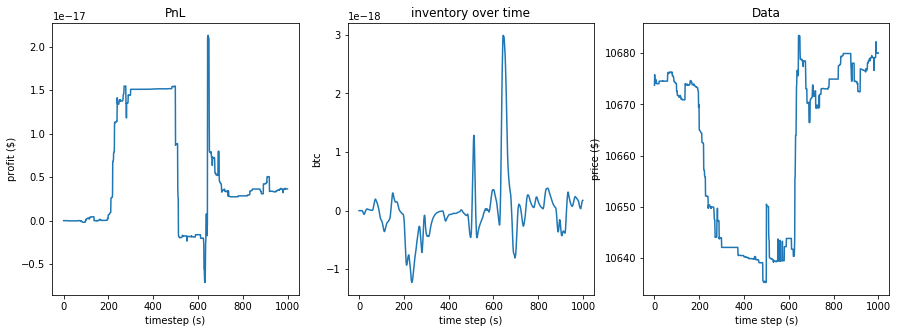

In [20]:
w = 15 # parameter for calibrating period. I.e., the bot look into the data 15 data points before the current point to project market moving in the next window.
N = w
s = ob_df.ms.tolist()[:1000]# load data into list
act_s = ob_df.ms.tolist()[1:1001] # data moves up 1 step to account for latency.
ds = np.array(act_s[1:]) - np.array(act_s[:-1])

# fit trend line on moving window
ord_list = [0] #start with 0 orders.
# start moving window
for i in range(w, len(s)):
    start = time.time()
    x = np.array(list(range(w))).reshape((-1, 1))
    y = np.array(s[i-w:i])
    model = LinearRegression() # the bot use the data 15 seconds before the current time and fit a linear regression to project price movement in the next window
    model.fit(x, y)
    ds_t = ds[i-w:i-1]
    #print (model.coef_, model.intercept_)
    tmp_ord_list = []
    print (np.mean(ds_t), np.std(ds_t))

  # create a set of projected data
    projs = []
    projsog = []
    for i in range(50):
        nxt_inc = np.random.normal(loc=np.mean(ds_t), scale=np.std(ds_t), size=w+1)
        proj_s = nxt_inc + np.array([model.coef_[0]*i + model.intercept_ for i in range(w, 2*w+1)])
        proj_s_org = proj_s
        if len(projsog) >= 1:
            projsog = np.vstack ((projsog, proj_s_org[1:]))
        else:
            projsog = proj_s_org[1:]
        #print (len(projsog), len(np.zeros(N)))
        projsog = np.vstack((projsog, np.zeros(N)))
        #proj_s_org = proj_s_org.T
        proj_s = proj_s[1:] - proj_s[:-1]
        if len(projs) >= 1:
            projs = np.vstack((projs, proj_s))
        else:
            projs = proj_s
        projs = np.vstack((projs, np.zeros(N)))
        #proj_s = proj_s.T
    projs = np.matrix(projs)
    projsog = np.matrix(projsog)
    projs = projs.T
    projsog = projsog.T

        # solve optimization problem on a window of time T=15
    #print (sum(ord_list))
    """
    The code block below makes use of CVXPy to solve an optimization.
    """
    # inputs:
    N = w # size of moving window
    max_pos = 1 # max position size

    # matrices A and B as shown in MPC model formulation
    ctr = 0
    A = []
    for i in range(2*50):
        A0 = np.zeros(2*50)
        if (i%2) == 0:
            A0[ctr:ctr+2] = [1,1]
            ctr += 2
        if len(A)>=1:
            A = np.vstack((A, A0))
        else:
            A = A0
    A = np.matrix(A)
    B = []
    for i in range(50):
        B += [0,1]
    B = np.matrix(B)
    B = B.T

    X = cvx.Variable((2*50,N+1)) # combination state vectors by time steps
    U = cvx.Variable((1,N)) # combination of actions vectors by time steps

    con = [X[:,0] == np.array([sum(ord_list),0]*50)] # constraint 1: starting condition, specified to be changed based on the current inventory of the bot itself
    con.extend([X[:,1:w+1] == A*X[:,0:w] + B*U]) # constraint 2: update condition
    con.extend([cvx.norm(U[0,j],'inf')<=max_pos for j in range(0,N)]) # constraint 3: maximum trading position
    con.extend([cvx.norm(X[0,:],'inf')<=1]) # constraint 4: maximum inventory size
    #con.extend([cvx.min(U[j])>=0.001 for j in range(0,2*50,2)])
    #con.extend([cvx.abs(cvx.max(U))>=2e-10])

    con.extend([X[j, -1] == 0 for j in range(0,2*50,2)]) #neutral exposure

    for i in range(2*50):
        if i == 0:
            tv_arr = cvx.tv(cvx.multiply(np.array(projsog[:,i].T)[0],X[i,1:w+1]))
            continue
        if i%2 == 0:
            cvx.vstack([tv_arr, cvx.tv(cvx.multiply(np.array(projsog[:,i].T)[0],X[i,1:w+1]))])
        else:
            cvx.vstack([tv_arr, 0])
    obj = cvx.Maximize(cvx.sum(cvx.diag(X[:,1:w+1]@projs)-tv_arr)) # objective function

    prob = cvx.Problem(obj, con) # insert objective function and constraints into cvxpy

    #output
    print(prob.solve(solver=cvx.ECOS, verbose=False)) # solve using cvxpy magic

    ord_list.append(U.value[0][0]) # the bot executes only the first action, the window moves the process repeats
    
ord_list = ord_list[1:] # discard the first (zero place-holder) action

# # plot result (inventory over time)
# plt.plot(list(range(14, 30)), X.value[0])

# plot the pnl of the bot
ord_list = [0]*w + ord_list
pnl = np.cumsum(np.cumsum(np.array(ord_list[:-1]))*ds)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(pnl)
plt.title('PnL')
plt.xlabel('timestep (s)')
plt.ylabel('profit ($)')

# plot inventory over time
plt.subplot(1,3,2)
plt.plot(np.cumsum(ord_list))
plt.title('inventory over time')
plt.ylabel('btc')
plt.xlabel('time step (s)')

# plot price time series
plt.subplot(1,3,3)
plt.plot(act_s)
plt.title('Data')
plt.xlabel('time step (s)')
plt.ylabel('price ($)')

Text(0, 0.5, 'profit ($)')

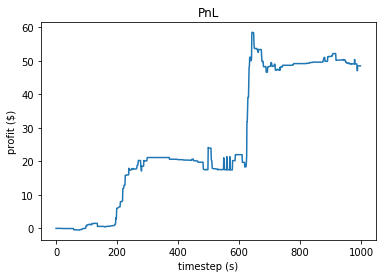

In [21]:
## fixed size performance -- this is effectively the position sizing layer mentioned in the paper
## only position size is scaled by sign - the position size changes are not recorded by the bot and hence not be reflected in the starting position X0 at each iteration.
ord_list_1 = [0.015*np.sign(item) for item in ord_list]
pnl = np.cumsum(np.cumsum(np.array(ord_list_1[:-1]))*ds)
plt.plot(pnl)
plt.title('PnL')
plt.xlabel('timestep (s)')
plt.ylabel('profit ($)')